# Development of a tennis match result prediction model

## Introduction
The objective of this analysis is to propose a model for predicting the outcome of tennis matches based solely on the ATP (source : https://www.kaggle.com/sijovm/atpdata), with the ultimate goal of making money on sports betting.

This notebook is organized as follows:

- **Exploration of the raw data:** This part aims to get to grips with the available data, understand the variables and the use that could be made of them to build the model,
- **Exploration of the processed data:** This section analyze the processed and the generated features for the model,
- **Model performance evaluation:** this section is about analyzing the performance of the trained model,
- **Conclusion:** in conclusion, we discuss possible improvements.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Import the packages
import os
import joblib 
import requests
from datetime import date
import pandas as pd 
import numpy as np

import shap

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from utils import (recap_dataframe, plot_confusion_matrix, features_importance)


project_dir = os.path.abspath(os.path.join(os.path.dirname(__name__), '..'))
data_path = os.path.join(project_dir , "data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploration of the raw data

In [3]:
# Load the dataset
df = pd.read_csv(os.path.join(data_path, "raw", "atp_matches_till_2022.csv"))
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")

# Quick overview of the first lines
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-2029,Dublin,Grass,32,A,1968-07-08,270,112411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-2029,Dublin,Grass,32,A,1968-07-08,271,126914,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-2029,Dublin,Grass,32,A,1968-07-08,272,209523,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-2029,Dublin,Grass,32,A,1968-07-08,273,100084,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-2029,Dublin,Grass,32,A,1968-07-08,274,100132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Main information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188161 entries, 0 to 188160
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   tourney_id          188161 non-null  object        
 1   tourney_name        188161 non-null  object        
 2   surface             185844 non-null  object        
 3   draw_size           188161 non-null  int64         
 4   tourney_level       188161 non-null  object        
 5   tourney_date        188161 non-null  datetime64[ns]
 6   match_num           188161 non-null  int64         
 7   winner_id           188161 non-null  int64         
 8   winner_seed         69694 non-null   float64       
 9   winner_entry        16270 non-null   object        
 10  winner_name         188161 non-null  object        
 11  winner_hand         188144 non-null  object        
 12  winner_ht           171924 non-null  float64       
 13  winner_ioc          188151 no

In [4]:
# Summarise those information and additional info in a DF
df_info_by_column = recap_dataframe(df)
df_info_by_column.head()

,column_dtype,value_count,n_unique,filling_factor,null_value,null_value_ratio
tourney_id,object,188161,8115,188161,0,0.000
tourney_name,object,188161,3998,188161,0,0.000
surface,object,188161,5,185844,2317,1.231
draw_size,int64,188161,18,188161,0,0.000
tourney_level,object,188161,5,188161,0,0.000


### Duplicated entries

In [5]:
print("Number of duplicated entries: ", len(df[df.duplicated()]))

Number of duplicated entries:  0


### Data completeness

#### Missing data by columns

In [8]:
# Missing data ratio in columns
fig = px.bar(x=df_info_by_column.index, y=df_info_by_column["null_value_ratio"])
fig.update_layout(title="Barplot of missing data ratio by column", yaxis_title="Ratio (%)", xaxis_title="Column name")
fig.show()

In [9]:
# We consider only matches after 1991, the data are more filled since this year
start_date = 1991
sample_df_info_by_column = recap_dataframe(df[df['tourney_date'].dt.year>=start_date])
sample_df_info_by_column["sample"] = "Sample: matches since 1991"
df_info_by_column["sample"] = "Whole dataset"
df_info_by_column = pd.concat([df_info_by_column, sample_df_info_by_column], axis=0)

In [10]:
# Missing data ratio in columns
fig = px.bar(df_info_by_column, x=df_info_by_column.index, y="null_value_ratio", color="sample")
fig.update_layout(title="Barplot of missing data ratio by column", yaxis_title="Ratio (%)", xaxis_title="Column name", barmode="group")
fig.show()

In [11]:
# Proportion de matches après 1991
print("Proportion : ", round((len(df[df['tourney_date'].dt.year>=start_date])/len(df))*100, 2), "%")
print("Taille échantillon : ", len(df[df['tourney_date'].dt.year>=start_date]))

Proportion :  54.34 %
Taille échantillon :  102251


In [12]:
# Cut off the data from 1991
start_date = 1991
df = df[df['tourney_date'].dt.year>=start_date]

# Drop columns with high missing data ratio (above-mentionned)
col_to_drop = ["draw_size", "loser_entry", "loser_seed", "winner_entry", "winner_seed"]
df = df.loc[:,~df.columns.isin(col_to_drop)]

df.shape

(102251, 44)

#### Missing data by rows

In [13]:
# Missing data by rows
df_info_by_row = recap_dataframe(df, axis=1)

In [14]:
fig = px.histogram(df_info_by_row, x="filling_factor")
fig.update_layout(title="Histogram of missing data count by row", yaxis_title="class size", xaxis_title="class of count", width=600, height=400)
fig.show()

In [15]:
# Drop rows with low filling ratio
df = df.loc[df.index.isin(df_info_by_row[df_info_by_row['filling_factor']>=25].index)]

### Exploration of categorical variables

- **Information on the match or the competition** : *tourney_id*, *tourney_name*, *tourney_date*, *tourney_level*

There are 7 levels of competitions ("G", M", "A", "C", "S", "F", "D"). The id format (*tourney_id*) made of the year of the competition and an id of the tournament. The date of the match (*tourney_date*) is in format YYYYMMDD. 

- **The conditions of the match** : *surface*; its is an important feature in predicting the outcome

In [16]:
df[df['tourney_level']=='G']["tourney_name"].apply(lambda x: x.title()).value_counts().reset_index()

,tourney_name,count
0,Roland Garros,4064
1,Us Open,4064
2,Australian Open,4063
3,Wimbledon,3934


In [17]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Répartition des catégories de compétitions", "Les compétitions de grands chelem"))

tmp_df = df['tourney_level'].value_counts().reset_index()
fig.add_trace(
    go.Bar(y=tmp_df["count"], x=tmp_df["tourney_level"]),
    row=1, col=1
)

tmp_df = df[df['tourney_level']=='G']["tourney_name"].apply(lambda x: x.title()).value_counts().reset_index()
fig.add_trace(
    go.Bar(y=tmp_df["count"], x=tmp_df["tourney_name"]),
    row=1, col=2
)

fig.update_layout(
    height=400, width=1200, yaxis_title="count", yaxis2_title="count", 
    xaxis_title="tourney_level", xaxis2_title="tourney_name", title_text="")
fig.show()


In [18]:
# Pie plot of "surface" values
fig = px.pie(
    df["surface"].value_counts(normalize=False).reset_index(),
    values="count", names="surface", 
    title="Diagramme en secteurs"
)
fig.update_layout(height=500, width=700)
fig.show()

In [19]:
# Top 10 winners and losers
n_players = 10
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=(f"Top {n_players} winners", f"Top {n_players} losers"))

tmp_df = df['winner_name'].value_counts().sort_values(ascending=False).reset_index().iloc[:n_players]
fig.add_trace(
    go.Bar(y=tmp_df["count"], x=tmp_df["winner_name"]),
    row=1, col=1
)

tmp_df = df["loser_name"].value_counts().sort_values(ascending=False).reset_index().iloc[:n_players]
fig.add_trace(
    go.Bar(y=tmp_df["count"], x=tmp_df["loser_name"]),
    row=1, col=2
)

fig.update_layout(
    height=400, width=1200, yaxis_title="count", yaxis2_title="count", 
    xaxis_title="player name", xaxis2_title="player name", title_text="")
fig.show()

### Exploration of float variables

In [21]:
# Mean statistics of matches by winner and loser
w_columns = []
l_columns = []
o_columns = []
for c in df.select_dtypes(include="float").columns:
    if ('l_' in c) or ('loser_' in c):
        l_columns.append(c)
    elif ("w_" in c) or ("winner_" in c):
        w_columns.append(c)
    else:
        o_columns.append(c)
#
stats_l = df[l_columns].mean()
stats_l = stats_l.reset_index()
stats_l['index'] = stats_l['index'].apply(lambda x: "".join(x.split("_")[1:]))

stats_l = stats_l.set_index('index')
stats_l.columns = ['loser']
#
stats_w = df[w_columns].mean()
stats_w = stats_w.reset_index()
stats_w['index'] = stats_w['index'].apply(lambda x: "".join(x.split("_")[1:]))

stats_w = stats_w.set_index('index')
stats_w.columns = ['winner']
#
stats = pd.concat([stats_l, stats_w], axis=1)

stats.round(2).head()

,loser,winner
index,,
ht,185.20,185.73
age,25.96,25.83
ace,4.83,6.52
df,3.49,2.74
svpt,80.91,78.07


In [22]:
fig = ff.create_annotated_heatmap(stats.T.round(2).values, y=[y for y in stats.columns], x=[x for x in stats.index], colorscale='bluered', xgap=3, ygap=3)
fig.update_layout(title="heatmap of the match statistics : mean", width=1200, height=400)
fig.show()

Following the winners or the losers, there are differences between the statistics.

### Exploration des variables entières

In [23]:
df.select_dtypes(include="int").columns

Index(['match_num', 'winner_id', 'loser_id', 'best_of'], dtype='object')

In [24]:
# victoires en deux sets ou 3 sets maximum
fig = px.bar(df['best_of'].apply(lambda x: f" {x} ").value_counts().reset_index(), y="count", x="best_of")
fig.update_layout(title="Maximum number of sets played", xaxis_title="max set", width=800, height=400)
fig.show()

## Feature engineering: Exploration of the processed data

The exploratory part allowed us to better understand the structuring of the dataset. The variables could be divided into three groups according to the type of information returned: 

**Variables on match conditions:**
- *tourney_level* : level of the tournament, 
- *surface* : type of land surface,
- *best_of* : maximum number of sets.

**Variables on the physical condition of the player:**
- *age* : the age,
- *hand* : the dominant hand,
- *ht*: the height, 
- *rank* : the rank,
- *rank_points* : nombre de point associé au classement.

**Match statistics** : that are not known before the match. However, using an average of the recent history can be an important input in the model to predict the outcome of the match.

- 1stIn* : 1st ball in a match
- *1stWon* : proportion of 1st service win
- *2ndWon* : proportion of 2nd service win
- *SvGms* : number of games played on the serve
- *ace* : number of ace in the match
- *bpFaced* : number of breaks played
- *bpSaved* : number of breaks won
- *df* : double fault during the match
- *svpt* : number of serves

To build our prediction model, we use the data on the match conditions, and the information available on the two players. The past performances of the player are extracted (a maximum window size in the history will be defined). Also, the history of direct confrontations between the two players could provide interesting information for training the model. A number of recent confrontations to consider is also defined.


To implement these different operations, functions are used to extract the players' peformances, the history of the confrontations and to build the new dataset.

In [25]:
# Load the processed dataset
new_df = pd.read_csv(os.path.join(data_path, "processed", "processed_data.csv"))

In [26]:
# Overview of the new dataframe
new_df.head()

,tourney_level,surface,best_of,target,player1_age,player1_hand,player1_ht,player1_rank,player1_rank_points,player2_age,...,player2_1stIn,player2_1stWon,player2_2ndWon,player2_SvGms,player2_ace,player2_bpFaced,player2_bpSaved,player2_df,player2_svpt,hist_confront
0,A,Clay,3,1,23.2,R,185.0,73.0,521.0,24.0,...,60.0,42.0,26.0,12.0,8.0,10.0,8.0,6.0,109.0,0
1,A,Clay,3,0,27.2,R,196.0,95.0,484.0,25.0,...,45.8,33.4,17.2,12.0,8.4,5.4,3.8,2.0,76.4,0
2,A,Hard,3,1,22.8,R,201.0,20.0,1243.0,23.2,...,36.8,26.4,16.0,10.0,3.0,3.6,2.2,0.8,64.4,-1
3,M,Clay,3,0,28.1,R,185.0,53.0,804.0,25.5,...,43.4,36.2,15.6,12.8,11.8,4.6,3.0,4.8,74.8,1
4,A,Clay,3,1,26.4,R,190.0,44.0,770.0,24.6,...,66.0,46.2,11.8,13.8,2.6,7.4,4.8,1.4,91.6,0


In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tourney_level        27 non-null     object 
 1   surface              27 non-null     object 
 2   best_of              27 non-null     int64  
 3   target               27 non-null     int64  
 4   player1_age          27 non-null     float64
 5   player1_hand         27 non-null     object 
 6   player1_ht           27 non-null     float64
 7   player1_rank         27 non-null     float64
 8   player1_rank_points  27 non-null     float64
 9   player2_age          27 non-null     float64
 10  player2_hand         27 non-null     object 
 11  player2_ht           27 non-null     float64
 12  player2_rank         27 non-null     float64
 13  player2_rank_points  27 non-null     float64
 14  player1_id           27 non-null     int64  
 15  player2_id           27 non-null     int64

In [28]:
new_df_info_by_row = recap_dataframe(new_df, axis=1)

In [31]:
# check for missing data in the new DF
fig = px.histogram(x=new_df_info_by_row.index, y=new_df_info_by_row["null_value_ratio"])
fig.update_layout(title="Histogram of null value ratio (%) by row", yaxis_title="class size", xaxis_title="class of ratio (%)", width=600, height=400)
fig.show()

#### Distribution of the label to be predicted

In [32]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Répartition des resultats de confrontations directes", "Répartition de la variable cible"))

result_dict = {"1": "player 1 won", "-1": "player 2 won", "0": "equality"}
tmp_df = new_df['hist_confront'].apply(lambda x: result_dict[str(x)]).value_counts().reset_index()
fig.add_trace(
    go.Bar(y=tmp_df["count"], x=tmp_df["hist_confront"]),
    row=1, col=1
)

tmp_df = new_df['target'].apply(lambda x: result_dict[str(x)]).value_counts().reset_index()
fig.add_trace(
    go.Bar(y=tmp_df["count"], x=tmp_df["target"]),
    row=1, col=2
)

fig.update_layout(
    height=400, width=1200, yaxis_title="effectif", yaxis2_title="effectif", 
    xaxis_title="result", xaxis2_title="resultat", title_text="")
fig.show()

#### Correlation

In [33]:
# correlation
df_cor=new_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

In [36]:
# Heatmap de la matrice de corrélation
fig = ff.create_annotated_heatmap(
    df_cor.mask(np.triu(np.ones(df_cor.shape, dtype=bool))).round(2).values, 
    y=[y for y in df_cor.columns], x=[x for x in df_cor.index], colorscale='bluered', xgap=3, ygap=3)
fig.update_layout(title="Matrice de corrélation", width=1400, height=1400)
fig.show()

Features with correlation above a given thresholds will be removed.

# Modelling: Model performance evaluation

Three models have been fine tune and the best model has been selected using an AutoML approach. The models are Logistic regression, random forest classifier and gradient boosting classifier.

In [37]:
with open(os.path.join(data_path, "final", "train_data.pkl"), "rb") as file:
    train_data = joblib.load(file)

#
X_train, X_test, y_train, y_test = train_data["X_train"], train_data["X_test"], train_data["y_train"], train_data["y_test"]

print("X train shape : {}, Y train shape : {}\nX test shape {},\
      Y test shape {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X train shape : (21, 21), Y train shape : (21,)
X test shape (6, 21),      Y test shape (6,)


In [38]:
model_path = os.path.join(project_dir, "models", "model.pkl")
with open(model_path, 'r') as file:
    model = joblib.load(model_path)

#
with open(os.path.join(data_path, "final", "prediction.pkl"), "rb") as f:
    y_pred = joblib.load(f)
#
model

RandomForestClassifier(n_jobs=-1, random_state=42)

#### Accuracy score

In [39]:
# Score test_set
print("Testing score: ", model.score(X_test, y_test))
#print("Training score: ", metrics.accuracy_score(y_test, model.predict(X_test), normalize=True))

Testing score:  0.6666666666666666


#### Confusion Matrix

In [40]:
# confusion matrix
plot_confusion_matrix(y_true=y_test, y_pred=y_pred, normalize=True)

In [41]:
ordered_feats_idx, shap_mean, shap_values = features_importance(model, X_train, nb_samples_used_for_shap=None)

#### Explainability and features importance 

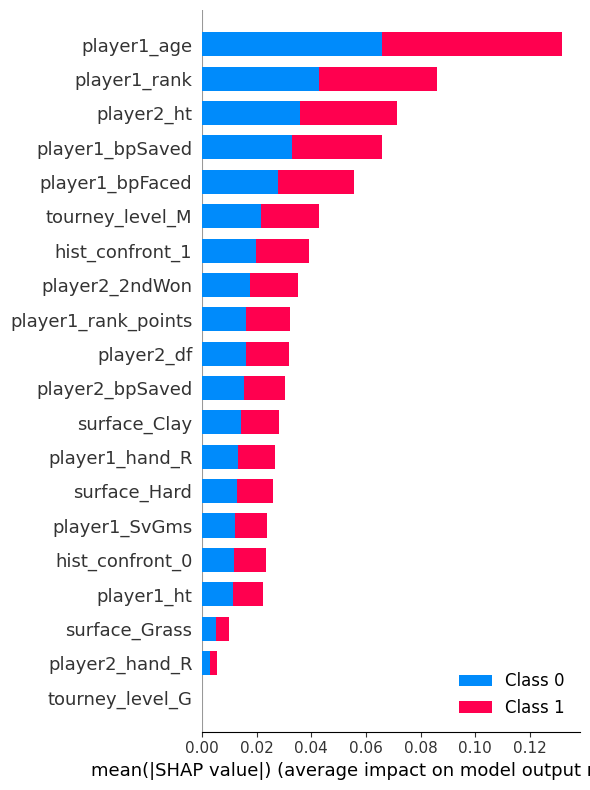

In [42]:
# Top 20 important features in the model
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=X_train.columns, max_display=20, plot_size=(6,8))

## Applications: Flask API and Dash App

In [14]:
# Try the API
url = "http://127.0.0.1:5000/predict/"

input_json = {
    "tourney_info": {
        "tourney_date": date.today().strftime("%Y-%m-%d"), 
        "match_num": 300, 
        "tourney_level": "M", 
        "surface": "Hard", 
        "best_of": 3
    }, 
    "player1": {
        "id": 103819, 
        "age": 36.17, 
        "hand": "R", 
        "ht": 185.0, 
        "rank": 2.0, 
        "rank_points": 7505.0
    }, 
    "player2": {
        "id": 104745, 
        "age": 31.35, 
        "hand": "L", 
        "ht": 185.0, 
        "rank": 1.0, 
        "rank_points": 9875.0
    }
}
response = requests.post(url, json=input_json)
response.json()

{'result': {'Predicted winner': 'player2',
  'Probability player 1 will be winner': 0.03999999910593033,
  'Probability player 2 will be winner': 0.9599999785423279}}

## Conclusion

- Deployment: An API for a deployment purpose has been implemented as well.
- Monitoring: set up a monitoring table and dashboard with alert on data and performance drifts
- Data ingestion: Automate the downloading and updating of the raw dataset 
- Re-train: set up a continuous improvement and re-training of the model. Thus, the models could be re-trained at defined frequencies or triggered based on the monitoring.